In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)


from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import tflscripts
import json
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn import tree
import pickle

configuration = tflscripts.read_configuration()
df = pd.read_pickle('results.p')

In [2]:
without_transfer = df.loc[df.type_of_transfer == 'No transfer']

def apply_accuracy_without_transfer(x):
    queried = without_transfer.query('source_device_name == "{}" & source_dataset == "{}" & features == "{}" & label == "{}" & classifier == "{}"'.format(
        x['source_device_name'],
        x['source_dataset'],
        x['features'],
        x['label'],
        x['classifier']
    ))

    if len(queried) > 0:
        return queried['accuracy_positive'].iloc[0]

    return -1

def apply_accuracy_without_transfer_dishes(x):
    return apply_accuracy_without_transfer_for_label(x, x['label'])

def to_accuracy_bin(acc):
    bins = [
        [0.0, 0.75],
        [0.75, 1.0]
    ]
    return [i for i, b in enumerate(bins) if b[0] <= acc and b[1] >= acc][0]


df['accuracy_bin'] = [to_accuracy_bin(a) for a in df['accuracy_positive']]
df['accuracy_without_transfer'] = df.apply(apply_accuracy_without_transfer, axis=1)

In [8]:
accuracies = {}

test_split = 0.33
# filtered = df.loc[df.accuracy_negative >= 0.95]
filtered = df
filtered = filtered.loc[filtered.type_of_transfer != 'No transfer']
# filtered = filtered.loc[filtered.type_of_transfer != 'Across spaces']

msk = np.random.rand(len(filtered)) <= test_split
train = filtered[msk]
test = filtered[~msk]

x_columns = [
    'features',
    'classifier',
    'label',
    'type_of_transfer',
    'accuracy_without_transfer',
    'accuracy_negative'
]

def to_x_and_y(filtered):

    X = filtered[x_columns]

    y = filtered['accuracy_bin']

    X = [dict(r.iteritems()) for _, r in X.iterrows()]
    y = y.values

    return X, y

X_train, y_train = to_x_and_y(train)
X_test, y_test = to_x_and_y(test)

ppl = Pipeline([
    ('vect', DictVectorizer()),
    ('impute', Imputer()),
    ('clf', RandomForestClassifier())
])

ppl.fit(X_train, y_train)
predicted = ppl.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(accuracy)

0.917278152823


In [9]:
predictions = pd.Series(predicted)
predictions.index = test.index
df['predictions'] = predictions

df_tested = df.loc[df.predictions >= 0]
counts = df_tested[['accuracy_bin', 'predictions']].groupby(['accuracy_bin', 'predictions']).size()
counts = pd.DataFrame(counts)
counts.columns = ['count']
counts.pivot_table(index=['accuracy_bin'], columns=['predictions'], values=['count'])

count     
predictions     0.0  1.0
accuracy_bin            
0             17958  537
1              1154  793

In [5]:
df_tested.to_pickle('results_with_accuracy_classified.p')

In [6]:
df_tested

,source_dataset,target_dataset,source_device,target_device,source_device_name,target_device_name,source_room,target_room,source_placement,target_placement,...,classifier,label,features,features_name,accuracy,accuracy_positive,accuracy_negative,accuracy_bin,accuracy_without_transfer,predictions
1,synergy-final-iter4,synergy-final-iter1,128.237.247.190,128.237.254.195,Mite 1 Table,Mite 3 Sink,synergy,synergy,Table,Sink,...,SVM,Kettle,.*,All,0.755102,0.324251,0.832842,0,0.443850,0.0
3,synergy-final-iter4,synergy-final-iter2,128.237.247.190,128.237.248.186,Mite 1 Table,Mite 2 Sink,synergy,synergy,Table,Sink,...,SVM,Kettle,.*,All,0.795918,0.469169,0.849538,0,0.443850,0.0
5,synergy-final-iter4,synergy-final-iter4,128.237.247.190,128.237.250.218,Mite 1 Table,Mite 4 Coffee,synergy,synergy,Table,Coffee,...,SVM,Kettle,.*,All,0.771228,0.730769,0.776916,0,0.443850,0.0
6,synergy-final-iter4,synergy-final-iter5,128.237.247.190,128.237.227.76,Mite 1 Table,Mite 2 Coffee,synergy,synergy,Table,Coffee,...,SVM,Kettle,.*,All,0.657570,0.845946,0.635166,1,0.443850,0.0
7,synergy-final-iter4,synergy-final-iter5,128.237.247.190,128.237.250.218,Mite 1 Table,Mite 4 Sink,synergy,synergy,Table,Sink,...,SVM,Kettle,.*,All,0.691145,0.756757,0.682885,1,0.443850,0.0
14,synergy-final-iter4,synergy-final-iter1,128.237.247.190,128.237.248.186,Mite 1 Table,Mite 2 Table,synergy,synergy,Table,Table,...,RandomForestClassifier,Kettle,.*,All,0.849263,0.013263,0.988106,0,0.873684,0.0
16,synergy-final-iter4,synergy-final-iter2,128.237.247.190,128.237.254.195,Mite 1 Table,Mite 3 Coffee,synergy,synergy,Table,Coffee,...,RandomForestClassifier,Kettle,.*,All,0.831833,0.006231,0.979888,0,0.873684,0.0
17,synergy-final-iter4,synergy-final-iter4,128.237.247.190,128.237.250.218,Mite 1 Table,Mite 4 Coffee,synergy,synergy,Table,Coffee,...,RandomForestClassifier,Kettle,.*,All,0.772671,0.379599,0.827927,0,0.873684,0.0
19,synergy-final-iter4,synergy-final-iter5,128.237.247.190,128.237.250.218,Mite 1 Table,Mite 4 Sink,synergy,synergy,Table,Sink,...,RandomForestClassifier,Kettle,.*,All,0.844666,0.000000,0.951004,0,0.873684,0.0
25,synergy-final-iter4,synergy-final-iter1,128.237.247.190,128.237.254.195,Mite 1 Table,Mite 3 Sink,synergy,synergy,Table,Sink,...,LogisticRegression,Kettle,.*,All,0.710537,0.351499,0.775320,0,0.423280,0.0


In [27]:
import pickle

class TransferableModelsForCase:
    def __init__(self, target_device_name, target_dataset):
        self.target_device_name = target_device_name
        self.target_dataset = target_dataset
        self.transferable_models = []
        
    def add_transferable_model(self, source_dataset, source_device_name, label,
                               classifier, features,
                               accuracy_positive, accuracy_negative):
        self.transferable_models.append({
            "source_dataset": source_dataset,
            "source_device_name": source_device_name,
            "label": label,
            "classifier": classifier,
            "features": features,
            "accuracy_positive": accuracy_positive,
            "accuracy_negative": accuracy_negative
        })

transferable_models = []
for _, case in cases.iterrows():
    device_name = case['target_device_name']
    dataset = case['target_dataset']
    
    models_for_case = TransferableModelsForCase(target_device_name=device_name,
                                               target_dataset=dataset)
    
    print(dataset, device_name)
    df_relevant = df_tested.loc[df_tested.target_device_name == device_name]
    df_relevant = df_relevant.loc[df_relevant.target_dataset == dataset]

    predicted_models = df_relevant.loc[df_relevant.predictions == 2]
    for i, row in predicted_models.iterrows():
        models_for_case.add_transferable_model(source_dataset=row['source_dataset'],
                                               source_device_name=row['source_device_name'],
                                               classifier=row['classifier'],
                                               label=row['label'],
                                               features=row['features'],
                                               accuracy_positive=row['accuracy_positive'],
                                               accuracy_negative=row['accuracy_negative'])
    transferable_models.append(models_for_case)

output = open('transferable_models.p', 'wb')
pickle.dump(transferable_models, output)
output.close()

synergy-final-iter1 Mite 3 Sink
synergy-final-iter2 Mite 3 Coffee
synergy-final-iter5 Mite 4 Sink
synergy-final-iter1 Mite 2 Table
synergy-final-iter4 Mite 1 Table
synergy-final-iter4 Mite 4 Coffee
synergy-final-iter5 Mite 2 Coffee
synergy-final-iter2 Mite 2 Sink
robotics-final Mite 1 Coffee
robotics-final Mite 4 Sink
scott-final-iter1 Mite 4 Right
scott-final-iter1 Mite 2 Left


In [20]:
filtered_x, filtered_y = to_x_and_y(filtered)

filtered_x = DictVectorizer().fit_transform(filtered_x)
filtered_x = pd.DataFrame(filtered_x.toarray())

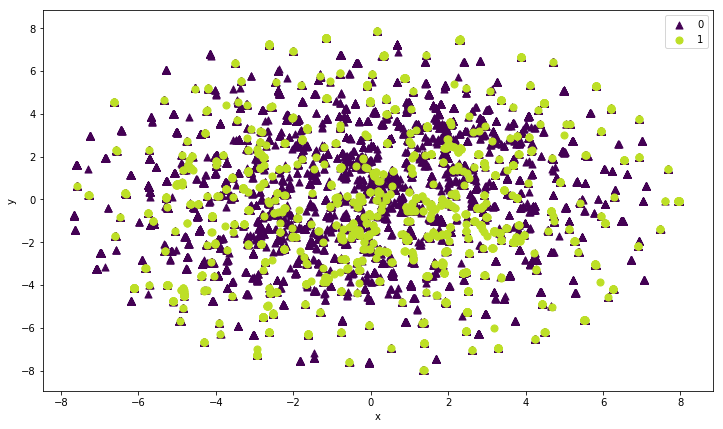

In [24]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import matplotlib.colors as colors

def plot_tsne(df, y, title=''):
    X = df.values
    # calculate tsne
    model = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    transformed = model.fit_transform(X)

    df = pd.DataFrame(transformed, columns=['x', 'y'])
    df['label'] = y

    fig, ax = plt.subplots()

    labels = df.label.unique()

    colormap = cm.viridis
    colorlist = [colors.rgb2hex(colormap(i)) for i in np.linspace(0, 0.9, len(labels))]
    markers = ['^', 'o', 'v', 's', 'd']

    for i, label in enumerate(labels):
        c = colorlist[i]
        subdf = df.loc[df.label == label]
        if len(subdf):
            subdf.plot.scatter('x', 'y',
                               marker=markers[i % len(markers)], s=50,
                               label=label, ax=ax, c=c)

    plt.title(title)

    ax.legend()
#     plt.savefig('plots/tsne.pdf')
    plt.show()

plot_tsne(filtered_x, filtered_y)